References
WESAD: https://archive.ics.uci.edu/dataset/465/wesad+wearable+stress+and+affect+detection \
TabTransformer:\
https://aravindkolli.medium.com/mastering-tabular-data-with-tabtransformer-a-comprehensive-guide-119f6dbf5a79 \
https://medium.com/@cristianleo120/the-math-behind-tabtransformer-78b78c12cfc1 \
https://towardsdatascience.com/transformers-for-tabular-data-b3e196fab6f4/\
https://towardsdatascience.com/transformers-for-tabular-data-tabtransformer-deep-dive-5fb2438da820/


Steps:
1. Import Dataset
2. Train-test split and Data Loader
3. Transformer/ Neural network
    1) Create a model
    2) Choose a loss function
    3) Set an optimizer 
    4) Run a training loop
        Calculate loss (Forward pass)
        Compute gradients (Backpropagation)
        Updating model parameters
4. Evaluation

In [1]:
# pip install "numpy==1.23.5" "scipy==1.10.1"
# pip install torch

In [1]:
#1. Import libraries
import os
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut, train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, matthews_corrcoef
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
# import module
import importlib
import train_test.train_test_loop_autoformer as train_test_loop_autoformer
from config import Config
importlib.reload(train_test_loop_autoformer)

from load_data import WESADDataset
from transformer_model import TabTransformer
from train_test.train_test_loop_autoformer import train_model, evaluate_model
from main import main

In [ ]:
DATASET_PATH = '/Users/kumar/Library/Mobile Documents/com~apple~CloudDocs/Phoenix/OVGU/HiWi2/Tasks/10_WESAD/WESAD.nosync'
# DATASET_PATH =  '/home/bumu60du/WESAD_Dataset'

ds = WESADDataset(DATASET_PATH)

# print(ds.data)
# print(ds.labels)

print(len(ds)) # How 6894?, all devices sampled at same rate?
input_sample, label_sample = ds[0]
print(len(input_sample)) # Time steps = 128, (window size is downsampled from 700 Hz to 32Hz, 128/32 = 4 seconds of data per window)
print(len(input_sample[0])) # ['ACC','Resp','EDA','Temp','ECG','EMG'], 6 sensors
print('Input sample:', input_sample) # 128 * 6
print('Label sample:', label_sample) # 0 for Baseline, 1 for Stress label for 4 seconds window

Window size (in samples): 128
Loaded 440 sliding windows for S2
Loaded 445 sliding windows for S3
Loaded 449 sliding windows for S4
Loaded 460 sliding windows for S5
Loaded 458 sliding windows for S6
Loaded 457 sliding windows for S7
Loaded 460 sliding windows for S8
Loaded 456 sliding windows for S9
Loaded 476 sliding windows for S10
Loaded 465 sliding windows for S11
Loaded 461 sliding windows for S13
Loaded 464 sliding windows for S14
Loaded 464 sliding windows for S15
Loaded 463 sliding windows for S16
Loaded 476 sliding windows for S17
6894
128
6
Input sample: tensor([[ 9.5370e-01,  2.2468e+00,  5.5277e+00,  2.9131e+01, -1.4182e-01,
         -6.0475e-03],
        [ 9.1147e-01,  2.3274e+00,  5.5262e+00,  2.9136e+01, -1.3497e-01,
          6.8507e-05],
        [ 9.0827e-01,  2.3982e+00,  5.5229e+00,  2.9145e+01, -9.1329e-02,
         -3.4008e-03],
        [ 9.2792e-01,  2.4003e+00,  5.5208e+00,  2.9142e+01, -1.2794e-01,
          5.1459e-05],
        [ 9.3718e-01,  2.4020e+00,  5.52

In [6]:
np.set_printoptions(threshold=np.inf)
print(ds.labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [ ]:
import pickle

# Create data directory if it doesn't exist
data_dir = os.path.join(os.path.dirname(DATASET_PATH), 'raw_data')
os.makedirs(data_dir, exist_ok=True)

# Save the raw dataset before normalization
raw_pickle_path = os.path.join(data_dir, 'wesad_raw.pkl')
with open(raw_pickle_path, 'wb') as f:
    pickle.dump({
        'data': ds.data,
        'labels': ds.labels
    }, f)

print(f"Raw dataset saved to: {raw_pickle_path}")

Raw dataset saved to: /Users/kumar/Library/Mobile Documents/com~apple~CloudDocs/Phoenix/OVGU/HiWi2/Tasks/10_WESAD/raw_data/wesad_raw.pkl


In [47]:
# Create data directory if it doesn't exist
data_dir = os.path.join(os.path.dirname(DATASET_PATH), 'raw_data')
os.makedirs(data_dir, exist_ok=True)

# Save the raw dataset before normalization
raw_pickle_path = os.path.join(data_dir, 'wesad_raw_lomo_emg.pkl')
with open(raw_pickle_path, 'wb') as f:
    pickle.dump({
        'data': ds.data,
        'labels': ds.labels
    }, f)

print(f"Raw dataset saved to: {raw_pickle_path}")

Raw dataset saved to: /Users/kumar/Library/Mobile Documents/com~apple~CloudDocs/Phoenix/OVGU/HiWi2/Tasks/10_WESAD/raw_data/wesad_raw_lomo_emg.pkl


In [48]:
# load pickle file:
pickle_path = os.path.join('/Users/kumar/Desktop/Projects/transformer_timeseries', 'wesad_raw_lomo_acc.pkl')
with open(pickle_path, 'rb') as f:
    saved_data = pickle.load(f)
    ds.data = saved_data['data']
    ds.labels = saved_data['labels']

In [51]:
print(len(ds.labels))
print(len(ds.data))

6894
6894


In [ ]:
# # 2.1 Train test size with ratios

# train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15

# n_total = len(ds)
# n_train = int(train_ratio * n_total)  
# n_val = int(val_ratio * n_total)      
# n_test = n_total - n_train - n_val    

# print(f"Total samples: {n_total}, Train: {n_train}, Validation: {n_val}, Test: {n_test}")

# # Train val test split
# train_ds = Subset(ds, range(0, n_train))
# val_ds   = Subset(ds, range(n_train, n_train + n_val))
# test_ds  = Subset(ds, range(n_train + n_val, n_total))


# # Data Loaders
# train_dataloader = DataLoader(train_ds, batch_size = 32, shuffle = False) # batch size = grouping 32 samples
# val_dataloader = DataLoader(val_ds, batch_size = 32, shuffle = False)
# test_dataloader = DataLoader(test_ds, batch_size = 32, shuffle = False)

# # Sample batch
# for batch_inputs, batch_labels in train_dataloader:
#     print('batch_inputs:', batch_inputs)
#     print('batch_labels:', batch_labels)
#     print(len(batch_inputs))
#     print(len(batch_inputs[0]))
#     break

Total samples: 6894, Train: 4825, Validation: 1034, Test: 1035
batch_inputs: tensor([[[ 7.5376e-01,  5.9662e-01,  2.5280e-01, -3.0084e+00, -6.0045e-01,
          -7.8230e-01],
         [-6.5244e-01,  6.1856e-01,  2.5237e-01, -3.0057e+00, -5.7163e-01,
           7.4942e-01],
         [-7.5893e-01,  6.3782e-01,  2.5145e-01, -2.9994e+00, -3.8830e-01,
          -1.1945e-01],
         ...,
         [-8.6707e-02,  1.3346e-01,  1.9340e-01, -2.9934e+00, -6.0667e-01,
          -2.3141e-01],
         [-2.0789e-01,  1.1483e-01,  1.9284e-01, -2.9996e+00,  1.1113e-01,
          -1.8646e-01],
         [-2.0856e-01,  1.0657e-01,  1.9205e-01, -2.9922e+00,  1.1807e-01,
           3.5171e-01]],

        [[-3.7929e-01,  9.2928e-02,  1.9144e-01, -2.9912e+00,  1.3195e-01,
          -2.4133e-01],
         [ 1.5650e-01,  7.1576e-02,  1.9063e-01, -2.9992e+00, -5.1575e-03,
           2.2788e-01],
         [ 2.4677e-01,  5.5967e-02,  1.9097e-01, -2.9987e+00,  5.7365e-02,
          -3.5603e-01],
         ...,
  

In [50]:
# 2.2 Subject bins for LOOCV

subject_counts = {'S2': 440, 'S3': 445, 'S4': 449,'S5': 460,'S6': 458,'S7': 457,'S8': 460,'S9': 456,
                  'S10': 476,'S11': 465,'S13': 461,'S14': 464,'S15': 464,'S16': 463, 'S17': 476}

subject_indices = {}
start = 0
for subject, count in subject_counts.items():
    end = start + count
    subject_indices[subject] = [start, end]
    start = end

print(subject_counts)
print(subject_indices)

{'S2': 440, 'S3': 445, 'S4': 449, 'S5': 460, 'S6': 458, 'S7': 457, 'S8': 460, 'S9': 456, 'S10': 476, 'S11': 465, 'S13': 461, 'S14': 464, 'S15': 464, 'S16': 463, 'S17': 476}
{'S2': [0, 440], 'S3': [440, 885], 'S4': [885, 1334], 'S5': [1334, 1794], 'S6': [1794, 2252], 'S7': [2252, 2709], 'S8': [2709, 3169], 'S9': [3169, 3625], 'S10': [3625, 4101], 'S11': [4101, 4566], 'S13': [4566, 5027], 'S14': [5027, 5491], 'S15': [5491, 5955], 'S16': [5955, 6418], 'S17': [6418, 6894]}


3. Transformer/ Neural network
    1) Create a model
    2) Choose a loss function
    3) Define a dataset
    4) Set an optimizer 
    5) Run a training loop
        Calculate loss (Forward pass)
        Compute gradients (Backpropagation)
        Updating model parameters

In [51]:
# Initialize model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

model = TabTransformer(
    num_features = 6,        # 6 sensor features
    num_classes = 2,         # Binary classification
    dim_embedding = 64,      # Embedding dimension
    num_heads = 4,           # Number of attention heads
    num_layers = 4,          # Number of transformer layers
    dropout = 0.1            # Dropout rate
).to(device)

print(model)
print(f"Using device: {device}")

Using device: mps
TabTransformer(
  (embedding): Linear(in_features=6, out_features=64, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)
Using device: mps


In [53]:
#save_dir = "/home/bumu60du/test"
save_dir = "/Users/kumar/Desktop/Projects/transformer_timeseries/checkpoints"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "best_model.pt")

In [ ]:
# LOOCV
loocv_results = []

for test_subject, test_range in subject_indices.items():
    print(f"\n{'='*60}")
    print(f"Testing on Subject: {test_subject}")
    print(f"{'='*60}")
    
    # Create test set
    test_indices = list(range(test_range[0], test_range[1]))

    # Train on all other subjects
    train_indices = []
    for subj, subj_range in subject_indices.items():
        if subj != test_subject:
            train_indices.extend(range(subj_range[0], subj_range[1]))
    
    # Get train and test data
    train_data = ds.data[train_indices]
    test_data = ds.data[test_indices]

    # Normalize using only training data
    train_means = train_data.mean(axis=(0, 1))
    train_stds = train_data.std(axis=(0, 1))

    # Apply normalization to train and test sets
    epsilon = 1e-8
    train_data_normalized = (train_data - train_means[None, None, :]) / (train_stds[None, None, :] + epsilon)
    test_data_normalized = (test_data - train_means[None, None, :]) / (train_stds[None, None, :] + epsilon)

    # Create datasets and dataloaders
    train_ds = TensorDataset(torch.FloatTensor(train_data_normalized), 
                            torch.LongTensor(ds.labels[train_indices]))
    test_ds = TensorDataset(torch.FloatTensor(test_data_normalized), 
                           torch.LongTensor(ds.labels[test_indices]))
    
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)
    
    print(f"Train: {len(train_ds)} samples, Test: {len(test_ds)} samples")
    
    # Initialize model
    model = TabTransformer(
        num_features=6, 
        num_classes=2, 
        dim_embedding=64, 
        num_heads=4, 
        num_layers=4,
        dropout=0.1
    ).to(device)
    
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.5, patience=3)

    # Training loop with early stopping
    history, best_model_state = train_model(
        model=model,
        train_dataloader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        n_epochs=n_epochs,
        device=device,
        patience=early_stopping_patience,  # Early stopping patience
        min_delta=early_stopping_min_delta  # Minimum improvement threshold
    )
    
    # Test evaluation with additional metrics
    test_acc, test_preds, test_labels = evaluate_model(
        model=model,
        best_model_state=best_model_state,
        test_loader=test_loader,
        device=device
    )

    # Calculate additional metrics
    print(test_labels,'\n',test_preds)
    test_f1 = f1_score(test_labels, test_preds)
    test_precision = precision_score(test_labels, test_preds)
    test_recall = recall_score(test_labels, test_preds)
    test_mcc = matthews_corrcoef(test_labels, test_preds)

    # Print results for current fold
    print(f"\n{test_subject} Results:")
    print(f"Accuracy: {test_acc:.2f}%")
    print(f"F1 Score: {test_f1:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"MCC: {test_mcc:.4f}\n")

    loocv_results.append({
        'subject': test_subject,
        'accuracy': test_acc,
        'f1_score': test_f1,
        'precision': test_precision,
        'recall': test_recall,
        'mcc': test_mcc,
        'predictions': test_preds,
        'true_labels': test_labels
    })

# Print final summary outside the loop
print(f"{'='*60}\nLOOCV Summary\n{'='*60}")
for r in loocv_results:
    print(f"{r['subject']}:,"
          f"Acc={r['accuracy']:.2f}%, F1={r['f1_score']:.4f}, "
          f"Prec={r['precision']:.4f}, Rec={r['recall']:.4f}, "
          f"MCC={r['mcc']:.4f}")


Testing on Subject: S2
Train: 6454 samples, Test: 440 samples
Epoch [1/25] Loss: 0.4044 | Acc: 79.58%
Current learning rate: 0.000100
Epoch [2/25] Loss: 0.1457 | Acc: 95.15%
Current learning rate: 0.000100
Epoch [3/25] Loss: 0.0869 | Acc: 97.12%
Current learning rate: 0.000100
Epoch [4/25] Loss: 0.0643 | Acc: 97.91%
Current learning rate: 0.000100
Epoch [5/25] Loss: 0.0532 | Acc: 98.34%
Current learning rate: 0.000100
Epoch [6/25] Loss: 0.0481 | Acc: 98.28%
Current learning rate: 0.000100
Epoch [7/25] Loss: 0.0380 | Acc: 98.74%
Current learning rate: 0.000100
Epoch [8/25] Loss: 0.0287 | Acc: 98.92%
Current learning rate: 0.000100
Epoch [9/25] Loss: 0.0274 | Acc: 99.10%
Current learning rate: 0.000100
Epoch [10/25] Loss: 0.0226 | Acc: 99.36%
Current learning rate: 0.000100
Epoch [11/25] Loss: 0.0227 | Acc: 99.26%
Current learning rate: 0.000100
Early stopping counter: 1/3
Epoch [12/25] Loss: 0.0195 | Acc: 99.27%
Current learning rate: 0.000100
Epoch [13/25] Loss: 0.0203 | Acc: 99.30%
C

/Users/kumar/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Epoch [1/25] Loss: 0.4082 | Acc: 79.33%
Current learning rate: 0.000100
Epoch [2/25] Loss: 0.1355 | Acc: 95.13%
Current learning rate: 0.000100
Epoch [3/25] Loss: 0.0768 | Acc: 97.29%
Current learning rate: 0.000100
Epoch [4/25] Loss: 0.0543 | Acc: 98.33%
Current learning rate: 0.000100
Epoch [5/25] Loss: 0.0378 | Acc: 98.90%
Current learning rate: 0.000100
Epoch [6/25] Loss: 0.0289 | Acc: 99.18%
Current learning rate: 0.000100
Epoch [7/25] Loss: 0.0227 | Acc: 99.36%
Current learning rate: 0.000100
Epoch [8/25] Loss: 0.0223 | Acc: 99.30%
Current learning rate: 0.000100
Early stopping counter: 1/3
Epoch [9/25] Loss: 0.0194 | Acc: 99.36%
Current learning rate: 0.000100
Epoch [10/25] Loss: 0.0164 | Acc: 99.50%
Current learning rate: 0.000100
Epoch [11/25] Loss: 0.0168 | Acc: 99.44%
Current learning rate: 0.000100
Early stopping counter: 1/3
Epoch [12/25] Loss: 0.0116 | Acc: 99.67%
Current learning rate: 0.000100
Epoch [13/25] Loss: 0.0134 | Acc: 99.52%
Current learning rate: 0.000100
Earl

In [1]:
from main import main

# Run the main function
if __name__ == "__main__":
    results = main()
    
    # Print final summary of results
    print(f"\nFinal Results Summary")
    print("=" * 60)
    for r in results:
        print(f"{r['subject']}:",
              f"Acc={r['metrics']['accuracy']:.2f}%, ",
              f"F1={r['metrics']['f1_score']:.4f}, ",
              f"Prec={r['metrics']['precision']:.4f}, ",
              f"Rec={r['metrics']['recall']:.4f}, ",
              f"MCC={r['metrics']['mcc']:.4f}")

    # Calculate and print mean metrics
    mean_metrics = {
        'accuracy': np.mean([r['metrics']['accuracy'] for r in results]),
        'f1_score': np.mean([r['metrics']['f1_score'] for r in results]),
        'precision': np.mean([r['metrics']['precision'] for r in results]),
        'recall': np.mean([r['metrics']['recall'] for r in results]),
        'mcc': np.mean([r['metrics']['mcc'] for r in results])
    }

    print(f"\nMean Metrics Across All Subjects:")
    print("=" * 60)
    print(f"Accuracy:  {mean_metrics['accuracy']:.2f}%")
    print(f"F1 Score:  {mean_metrics['f1_score']:.4f}")
    print(f"Precision: {mean_metrics['precision']:.4f}")
    print(f"Recall:    {mean_metrics['recall']:.4f}")
    print(f"MCC:       {mean_metrics['mcc']:.4f}")

Using device: cpu


FileNotFoundError: [Errno 2] No such file or directory: '/home/bumu60du/transformers_ovgu/wesad_raw.pkl'

In [3]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 3.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.3 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.5 MB/s eta 0:00:00


In [12]:
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 6.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 MB 9.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 2.9.0
    Uninstalling torch-2.9.0:
      Successfully uninstalled torch-2.9.0


In [20]:
from time import perf_counter
from typing import Dict, Tuple, Optional, Iterable

import torch
import numpy as np
from matplotlib import pyplot as plt

from torch import nn
from torch.utils.data import DataLoader, default_collate
import optuna
from optuna.trial import TrialState

In [18]:
class MultiplePruners(optuna.pruners.BasePruner):
    def __init__(
        self,
        pruners: Iterable[optuna.pruners.BasePruner],
        pruning_condition: str = "any") -> None:

        self._pruners = tuple(pruners)

        self._pruning_condition_check_fn = None
        if pruning_condition == "any":
            self._pruning_condition_check_fn = any
        elif pruning_condition == "all":
            self._pruning_condition_check_fn = all
        else:
            raise ValueError(f"Invalid pruning ({pruning_condition}) condition passed!")
        assert self._pruning_condition_check_fn is not None

    def prune(
        self,
        study: optuna.study.Study,
        trial: optuna.trial.FrozenTrial) -> bool:

         return self._pruning_condition_check_fn(pruner.prune(study, trial) for pruner in self._pruners)

In [19]:
class EarlyStopping:
    def __init__(self,
                 model: nn.Module,
                 patience: int,
                 direction: str = "min",
                 min_delta: float = 0.0001,
                 verbose: bool = False):
        if direction not in ["min", "max"]:
            raise ValueError("direction should be 'min' or 'max', you passed {}".format(direction))
        self.best_state_dict = {key: val.clone() for key, val in model.state_dict().items()}
        self.best_value = np.inf if direction == "min" else -np.inf
        self.direction = direction
        self.min_delta = min_delta
        self.model = model

        self.patience = patience
        self.disappointment = 0
        self.verbose = verbose

    def update(self,
               value: torch.tensor) -> bool:
        if ((self.direction == "min" and value < self.best_value - self.min_delta) 
            or (self.direction == "max" and value > self.best_value + self.min_delta)):
            self.best_value = value
            for key, val in self.model.state_dict().items():
                self.best_state_dict[key] = val.clone()
            self.disappointment = 0
            if self.verbose:
                print("New best value found; no longer disappointed")
            return 0
        else:
            self.disappointment += 1
            if self.verbose:
                print("EarlyStopping disappointment increased to {}".format(self.disappointment))

            if self.disappointment > self.patience:
                if self.verbose:
                    print("EarlyStopping has become too disappointed; now would be a good time to cancel training")
                    print("Restoring best model from state_dict")
                self.model.load_state_dict(self.best_state_dict)
                return True
            else:
                return False

In [ ]:
import optuna
from optuna.trial import Trial

def objective(trial: Trial):
    # Suggest hyperparameters
    dim_embedding = trial.suggest_categorical("dim_embedding", [32, 64, 128, 256])
    num_heads = trial.suggest_categorical("num_heads", [2, 4, 8])
    num_layers = trial.suggest_int("num_layers", 2, 6)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    
    # Aggregated results across LOOCV folds
    fold_accuracies = []
    
    for test_subject, test_range in subject_indices.items():
        # Your existing LOOCV split logic
        test_indices = list(range(test_range[0], test_range[1]))
        train_indices = []
        for subj, subj_range in subject_indices.items():
            if subj != test_subject:
                train_indices.extend(range(subj_range[0], subj_range[1]))
        
        # Normalize data
        train_data = ds.data[train_indices]
        test_data = ds.data[test_indices]
        train_means = train_data.mean(axis=(0, 1))
        train_stds = train_data.std(axis=(0, 1))
        epsilon = 1e-8
        train_data_normalized = (train_data - train_means[None, None, :]) / (train_stds[None, None, :] + epsilon)
        test_data_normalized = (test_data - train_means[None, None, :]) / (train_stds[None, None, :] + epsilon)
        
        # Create dataloaders
        train_ds = TensorDataset(torch.FloatTensor(train_data_normalized), 
                                torch.LongTensor(ds.labels[train_indices]))
        test_ds = TensorDataset(torch.FloatTensor(test_data_normalized), 
                               torch.LongTensor(ds.labels[test_indices]))
        
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
        
        # Initialize model with trial hyperparameters
        model = TabTransformer(
            num_features=6, 
            num_classes=2, 
            dim_embedding=dim_embedding, 
            num_heads=num_heads, 
            num_layers=num_layers,
            dropout=dropout
        ).to(device)
        
        criterion = nn.CrossEntropyLoss().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
        
        # Train model
        history, best_model_state = train_model(
            model=model,
            train_dataloader=train_loader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            n_epochs=20,  # Reduced for faster tuning
            device=device,
            patience=5,
            min_delta=0.001
        )
        
        # Evaluate
        test_acc, _, _ = evaluate_model(
            model=model,
            best_model_state=best_model_state,
            test_loader=test_loader,
            device=device
        )
        
        fold_accuracies.append(test_acc)
        
        # Report intermediate value for pruning
        trial.report(np.mean(fold_accuracies), len(fold_accuracies))
        
        # Prune trial if it's not promising
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    # Return mean accuracy across all folds
    return np.mean(fold_accuracies)

# Create study and optimize
study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=3)
)

study.optimize(objective, n_trials=50, timeout=3600)  # 50 trials or 1 hour

# Print best hyperparameters
print("Best trial:")
print(f"  Value: {study.best_trial.value:.2f}%")
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

In [11]:
from data.loader_muse import MUSEDataset
import numpy as np

In [15]:
dataset = MUSEDataset(
    data_path='/Users/kumar/Library/Mobile Documents/com~apple~CloudDocs/Phoenix/OVGU/HiWi2/c4_muse_physio.nosync',
    window_size=128,
    overlap=0.0,
    target_fs=32
)
    
print(f"\nDataset loaded successfully!")
print(f"Total windows: {len(dataset)}")
print(f"Unique subjects: {len(np.unique(dataset.subjects))}")
print(f"Data shape per window: {dataset.data[0].shape}")
print(f"Label distribution: {np.bincount(dataset.labels)}")

# Test data loading
sample_data, sample_label = dataset[0]
print(f"\nSample data shape: {sample_data.shape}")
print(f"Sample label: {sample_label}")

Found 69 subjects/sessions
Loaded 4 windows for subject 1
Loaded 4 windows for subject 10
Loaded 4 windows for subject 11
Skipping subject 13 - no windows created
Loaded 4 windows for subject 14
Skipping subject 15 - no windows created
Loaded 4 windows for subject 16
Skipping subject 17 - no windows created
Loaded 5 windows for subject 18
Loaded 4 windows for subject 19
Skipping subject 2 - no windows created
Loaded 4 windows for subject 20
Loaded 4 windows for subject 21
Loaded 4 windows for subject 22
Loaded 4 windows for subject 23
Loaded 4 windows for subject 24
Loaded 4 windows for subject 26
Loaded 4 windows for subject 27
Loaded 4 windows for subject 29
Skipping subject 3 - no windows created
Loaded 4 windows for subject 30
Loaded 4 windows for subject 31
Loaded 4 windows for subject 32
Loaded 4 windows for subject 33
Loaded 4 windows for subject 34
Loaded 4 windows for subject 35
Loaded 4 windows for subject 36
Skipping subject 37 - no windows created
Loaded 4 windows for subje

In [14]:
# Display dataset information
print(f"\n{'='*60}")
print(f"MUSE Dataset Summary")
print(f"{'='*60}")
print(f"Total windows: {len(dataset)}")
print(f"Unique subjects: {len(np.unique(dataset.subjects))}")
print(f"Data shape per window: {dataset.data[0].shape}")
print(f"Number of features: {dataset.data[0].shape[1]}")
print(f"\nLabel distribution:")
unique_labels, counts = np.unique(dataset.labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"  Label {label}: {count} windows ({count/len(dataset)*100:.2f}%)")

# Test data loading
sample_data, sample_label = dataset[0]
print(f"\nSample data shape: {sample_data.shape}")
print(f"Sample label: {sample_label}")


MUSE Dataset Summary
Total windows: 222
Unique subjects: 55
Data shape per window: (128, 108)
Number of features: 108

Label distribution:
  Label 0: 222 windows (100.00%)

Sample data shape: torch.Size([128, 108])
Sample label: 0


In [8]:
# Metrics

In [1]:
log_text_non = """
S2: Acc=65.00%, F1=0.5121, Prec=0.4225, Rec=0.6500, MCC=0.0000
S3: Acc=89.66%, F1=0.8981, Prec=0.9068, Rec=0.8966, MCC=0.7907
S4: Acc=65.03%, F1=0.5171, Prec=0.7731, Rec=0.6503, MCC=0.0903
S5: Acc=24.78%, F1=0.1450, Prec=0.1213, Rec=0.2478, MCC=-0.4522
S6: Acc=79.04%, F1=0.7623, Prec=0.8375, Rec=0.7904, MCC=0.5538
S7: Acc=35.01%, F1=0.1816, Prec=0.1226, Rec=0.3501, MCC=0.0000
S8: Acc=76.30%, F1=0.7667, Prec=0.8256, Rec=0.7630, MCC=0.5802
S9: Acc=71.05%, F1=0.6648, Prec=0.7196, Rec=0.7105, MCC=0.3168
S10: Acc=69.12%, F1=0.6164, Prec=0.7939, Rec=0.6912, MCC=0.3541
S11: Acc=36.99%, F1=0.2049, Prec=0.7686, Rec=0.3699, MCC=0.0499
S13: Acc=80.04%, F1=0.7814, Prec=0.8255, Rec=0.8004, MCC=0.5670
S14: Acc=99.14%, F1=0.9914, Prec=0.9914, Rec=0.9914, MCC=0.9815
S15: Acc=97.41%, F1=0.9740, Prec=0.9745, Rec=0.9741, MCC=0.9445
S16: Acc=100.00%, F1=1.0000, Prec=1.0000, Rec=1.0000, MCC=1.0000
S17: Acc=94.33%, F1=0.9422, Prec=0.9480, Rec=0.9433, MCC=0.8829
"""

log_text_acc = """
  S2: Acc=62.73%, F1=0.5011, Prec=0.4172, Rec=0.6273, MCC=-0.1119
  S3: Acc=68.31%, F1=0.5898, Prec=0.7880, Rec=0.6831, MCC=0.2819
  S4: Acc=65.26%, F1=0.5221, Prec=0.7741, Rec=0.6526, MCC=0.1108
  S5: Acc=56.96%, F1=0.5631, Prec=0.5583, Rec=0.5696, MCC=0.0290
  S6: Acc=75.98%, F1=0.7626, Prec=0.8566, Rec=0.7598, MCC=0.6119
  S7: Acc=35.01%, F1=0.1816, Prec=0.1226, Rec=0.3501, MCC=0.0000
  S8: Acc=67.17%, F1=0.6715, Prec=0.6713, Rec=0.6717, MCC=0.2911
  S9: Acc=72.15%, F1=0.6797, Prec=0.7347, Rec=0.7215, MCC=0.3495
  S10: Acc=62.61%, F1=0.4885, Prec=0.7668, Rec=0.6261, MCC=0.1017
  S11: Acc=67.74%, F1=0.6718, Prec=0.8286, Rec=0.6774, MCC=0.5110
  S13: Acc=91.32%, F1=0.9102, Prec=0.9222, Rec=0.9132, MCC=0.8164
  S14: Acc=37.72%, F1=0.2252, Prec=0.6905, Rec=0.3772, MCC=0.0658
  S15: Acc=98.71%, F1=0.9870, Prec=0.9873, Rec=0.9871, MCC=0.9724
  S16: Acc=100.00%, F1=1.0000, Prec=1.0000, Rec=1.0000, MCC=1.0000
  S17: Acc=93.28%, F1=0.9335, Prec=0.9418, Rec=0.9328, MCC=0.8691
"""

log_text_resp = """
  S2: Acc=64.77%, F1=0.5110, Prec=0.4220, Rec=0.6477, MCC=-0.0350
  S3: Acc=27.19%, F1=0.1537, Prec=0.1072, Rec=0.2719, MCC=-0.4136
  S4: Acc=64.81%, F1=0.5120, Prec=0.7722, Rec=0.6481, MCC=0.0638
  S5: Acc=0.87%, F1=0.0060, Prec=0.0046, Rec=0.0087, MCC=-0.9810
  S6: Acc=75.55%, F1=0.7215, Prec=0.7862, Rec=0.7555, MCC=0.4537
  S7: Acc=35.01%, F1=0.1816, Prec=0.1226, Rec=0.3501, MCC=0.0000
  S8: Acc=51.09%, F1=0.5199, Prec=0.5454, Rec=0.5109, MCC=0.0189
  S9: Acc=83.55%, F1=0.8246, Prec=0.8499, Rec=0.8355, MCC=0.6385
  S10: Acc=61.76%, F1=0.4733, Prec=0.3836, Rec=0.6176, MCC=-0.0359
  S11: Acc=36.56%, F1=0.1957, Prec=0.1337, Rec=0.3656, MCC=0.0000
  S13: Acc=70.72%, F1=0.6341, Prec=0.7991, Rec=0.7072, MCC=0.3579
  S14: Acc=92.03%, F1=0.9185, Prec=0.9240, Rec=0.9203, MCC=0.8288
  S15: Acc=92.89%, F1=0.9270, Prec=0.9361, Rec=0.9289, MCC=0.8517
  S16: Acc=96.76%, F1=0.9672, Prec=0.9692, Rec=0.9676, MCC=0.9309
  S17: Acc=98.74%, F1=0.9874, Prec=0.9876, Rec=0.9874, MCC=0.9734
"""

log_text_temp = """
  S2: Acc=75.45%, F1=0.7218, Prec=0.7766, Rec=0.7545, MCC=0.4390
  S3: Acc=70.79%, F1=0.7108, Prec=0.7976, Rec=0.7079, MCC=0.5000
  S4: Acc=78.84%, F1=0.7582, Prec=0.8406, Rec=0.7884, MCC=0.5506
  S5: Acc=33.26%, F1=0.1747, Prec=0.1185, Rec=0.3326, MCC=-0.1813
  S6: Acc=76.64%, F1=0.7409, Prec=0.7847, Rec=0.7664, MCC=0.4748
  S7: Acc=35.01%, F1=0.1816, Prec=0.1226, Rec=0.3501, MCC=0.0000
  S8: Acc=99.78%, F1=0.9978, Prec=0.9978, Rec=0.9978, MCC=0.9953
  S9: Acc=71.71%, F1=0.6933, Prec=0.7089, Rec=0.7171, MCC=0.3375
  S10: Acc=39.08%, F1=0.2548, Prec=0.5362, Rec=0.3908, MCC=0.0050
  S11: Acc=45.16%, F1=0.3604, Prec=0.7806, Rec=0.4516, MCC=0.2329
  S13: Acc=56.18%, F1=0.5573, Prec=0.5537, Rec=0.5618, MCC=0.0314
  S14: Acc=98.71%, F1=0.9871, Prec=0.9875, Rec=0.9871, MCC=0.9727
  S15: Acc=84.48%, F1=0.8368, Prec=0.8570, Rec=0.8448, MCC=0.6675
  S16: Acc=100.00%, F1=1.0000, Prec=1.0000, Rec=1.0000, MCC=1.0000
  S17: Acc=95.80%, F1=0.9574, Prec=0.9607, Rec=0.9580, MCC=0.9127
"""

log_text_eda = """
  S2: Acc=64.77%, F1=0.5110, Prec=0.4220, Rec=0.6477, MCC=-0.0350
  S3: Acc=22.47%, F1=0.2388, Prec=0.2678, Rec=0.2247, MCC=-0.5512
  S4: Acc=64.59%, F1=0.5069, Prec=0.4172, Rec=0.6459, MCC=0.0000
  S5: Acc=61.74%, F1=0.6179, Prec=0.7364, Rec=0.6174, MCC=0.3530
  S6: Acc=94.54%, F1=0.9444, Prec=0.9488, Rec=0.9454, MCC=0.8827
  S7: Acc=24.95%, F1=0.2650, Prec=0.2844, Rec=0.2495, MCC=-0.5605
  S8: Acc=97.61%, F1=0.9761, Prec=0.9761, Rec=0.9761, MCC=0.9485
  S9: Acc=75.00%, F1=0.7529, Prec=0.7587, Rec=0.7500, MCC=0.4698
  S10: Acc=97.90%, F1=0.9790, Prec=0.9790, Rec=0.9790, MCC=0.9554
  S11: Acc=55.05%, F1=0.5452, Prec=0.6567, Rec=0.5505, MCC=0.2149
  S13: Acc=78.96%, F1=0.7882, Prec=0.7875, Rec=0.7896, MCC=0.5384
  S14: Acc=98.06%, F1=0.9805, Prec=0.9809, Rec=0.9806, MCC=0.9583
  S15: Acc=39.87%, F1=0.3424, Prec=0.5034, Rec=0.3987, MCC=-0.0416
  S16: Acc=72.57%, F1=0.7257, Prec=0.8438, Rec=0.7257, MCC=0.5695
  S17: Acc=100.00%, F1=1.0000, Prec=1.0000, Rec=1.0000, MCC=1.0000
"""

log_text_ecg = """
  S2: Acc=65.00%, F1=0.5121, Prec=0.4225, Rec=0.6500, MCC=0.0000
  S3: Acc=73.93%, F1=0.6981, Prec=0.7762, Rec=0.7393, MCC=0.4193
  S4: Acc=88.42%, F1=0.8776, Prec=0.9018, Rec=0.8842, MCC=0.7554
  S5: Acc=11.09%, F1=0.0759, Prec=0.0656, Rec=0.1109, MCC=-0.7599
  S6: Acc=77.07%, F1=0.7336, Prec=0.8309, Rec=0.7707, MCC=0.5123
  S7: Acc=35.01%, F1=0.1816, Prec=0.1226, Rec=0.3501, MCC=0.0000
  S8: Acc=62.17%, F1=0.6247, Prec=0.6287, Rec=0.6217, MCC=0.1988
  S9: Acc=82.46%, F1=0.8137, Prec=0.8343, Rec=0.8246, MCC=0.6096
  S10: Acc=88.03%, F1=0.8743, Prec=0.8996, Rec=0.8803, MCC=0.7577
  S11: Acc=41.72%, F1=0.3045, Prec=0.7296, Rec=0.4172, MCC=0.1546
  S13: Acc=84.38%, F1=0.8323, Prec=0.8669, Rec=0.8438, MCC=0.6687
  S14: Acc=98.49%, F1=0.9849, Prec=0.9849, Rec=0.9849, MCC=0.9674
  S15: Acc=91.59%, F1=0.9132, Prec=0.9258, Rec=0.9159, MCC=0.8254
  S16: Acc=82.07%, F1=0.8024, Prec=0.8601, Rec=0.8207, MCC=0.6284
  S17: Acc=98.32%, F1=0.9831, Prec=0.9836, Rec=0.9832, MCC=0.9647
"""

log_text_emg = """
  S2: Acc=65.00%, F1=0.5121, Prec=0.4225, Rec=0.6500, MCC=0.0000
  S3: Acc=56.85%, F1=0.5519, Prec=0.5437, Rec=0.5685, MCC=0.0090
  S4: Acc=91.54%, F1=0.9122, Prec=0.9252, Rec=0.9154, MCC=0.8203
  S5: Acc=2.83%, F1=0.0192, Prec=0.0146, Rec=0.0283, MCC=-0.9386
  S6: Acc=65.94%, F1=0.6533, Prec=0.8260, Rec=0.6594, MCC=0.4907
  S7: Acc=35.01%, F1=0.1816, Prec=0.1226, Rec=0.3501, MCC=0.0000
  S8: Acc=59.35%, F1=0.5922, Prec=0.6928, Rec=0.5935, MCC=0.2882
  S9: Acc=75.22%, F1=0.7323, Prec=0.7528, Rec=0.7522, MCC=0.4289
  S10: Acc=61.97%, F1=0.4743, Prec=0.3841, Rec=0.6197, MCC=0.0000
  S11: Acc=36.56%, F1=0.1957, Prec=0.1337, Rec=0.3656, MCC=0.0000
  S13: Acc=75.05%, F1=0.7090, Prec=0.8036, Rec=0.7505, MCC=0.4595
  S14: Acc=99.35%, F1=0.9935, Prec=0.9936, Rec=0.9935, MCC=0.9862
  S15: Acc=95.04%, F1=0.9496, Prec=0.9540, Rec=0.9504, MCC=0.8958
  S16: Acc=100.00%, F1=1.0000, Prec=1.0000, Rec=1.0000, MCC=1.0000
  S17: Acc=98.11%, F1=0.9810, Prec=0.9817, Rec=0.9811, MCC=0.9603
"""

In [ ]:
import re
import pandas as pd

# Dictionary of all log text files
log_texts = {
    "None": log_text_non,
    "ACC": log_text_acc,
    "RESP": log_text_resp,
    "TEMP": log_text_temp,
    "EDA": log_text_eda,
    "ECG": log_text_ecg,
    "EMG": log_text_emg
}

# Regex pattern to extract metrics
pattern = re.compile(
    r"(S\d+):\s+Acc=([\d.]+)%.*, F1=([\d.]+).*MCC=([-.\d]+)"
)

# Dictionary to store DataFrames for each modality
all_metrics = {}

# Loop through all log_text files
for modality, log_text in log_texts.items():
    rows = []
    for match in pattern.finditer(log_text):
        subject, acc, f1, mcc = match.groups()
        rows.append({
            "subject": subject,
            "accuracy": float(acc) / 100.0,  # convert to [0,1]
            "f1": float(f1),
            "mcc": float(mcc)
        })
    
    # Create DataFrame and store it
    all_metrics[modality] = pd.DataFrame(rows).set_index("subject")

# Create a combined DataFrame with F1 scores for each modality
acc_combined = pd.DataFrame({
    modality: df['accuracy'] 
    for modality, df in all_metrics.items()
})

f1_combined = pd.DataFrame({
    modality: df['f1'] 
    for modality, df in all_metrics.items()
})

mcc_combined = pd.DataFrame({
    modality: df['mcc'] 
    for modality, df in all_metrics.items()
})


print("Combined F1 Scores:")
print(f1_combined)

In [37]:
delta_acc = acc_combined.sub(acc_combined["None"], axis=0)
delta_acc['None'] = acc_combined["None"]

delta_f1 = f1_combined.sub(f1_combined["None"], axis=0)
delta_f1['None'] = f1_combined["None"]

delta_mcc = mcc_combined.sub(mcc_combined["None"], axis=0)
delta_mcc['None'] = mcc_combined["None"]

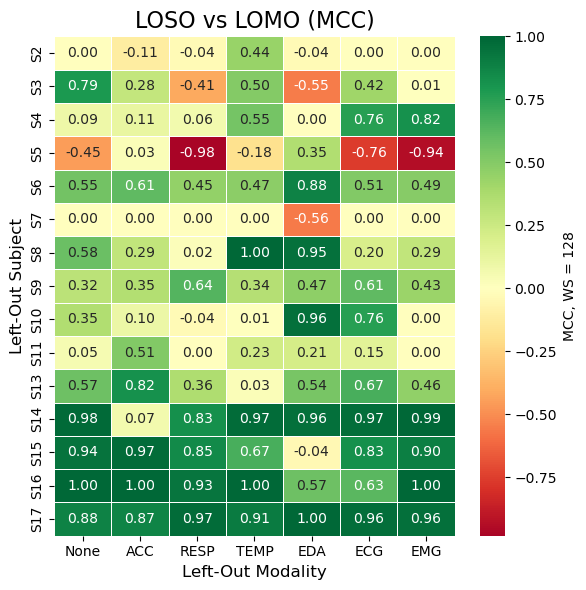

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

sns.heatmap(
    mcc_combined,
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",
    center=0,
    linewidths=0.5,
    cbar_kws={"label": "MCC, WS = 128"}
)

plt.title("LOSO vs LOMO (MCC)", fontsize=16)
plt.xlabel("Left-Out Modality", fontsize=12)
plt.ylabel("Left-Out Subject", fontsize=12)

plt.tight_layout()
plt.show()

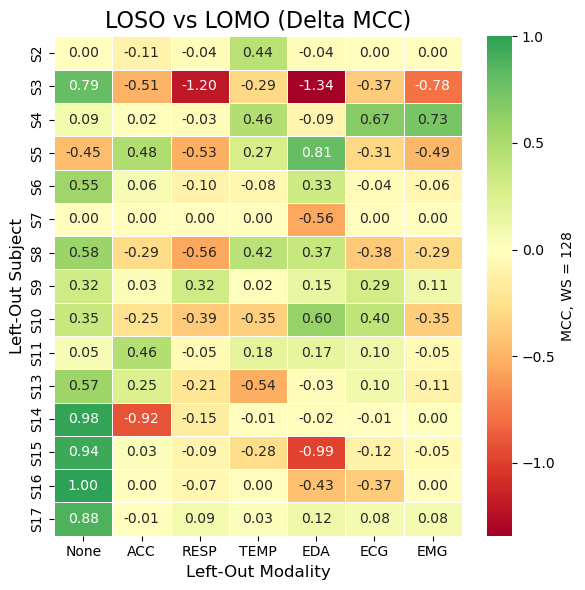

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

sns.heatmap(
    delta_mcc,
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",
    center=0,
    linewidths=0.5,
    cbar_kws={"label": "MCC, WS = 128"}
)

plt.title("LOSO vs LOMO (Delta MCC)", fontsize=16)
plt.xlabel("Left-Out Modality", fontsize=12)
plt.ylabel("Left-Out Subject", fontsize=12)

plt.tight_layout()
plt.show()

In [7]:
log_text_tabular_transformer = """
  S2: Acc=65.00%, F1=0.5121, Prec=0.4225, Rec=0.6500, MCC=0.0000
  S3: Acc=89.66%, F1=0.8981, Prec=0.9068, Rec=0.8966, MCC=0.7907
  S4: Acc=65.03%, F1=0.5171, Prec=0.7731, Rec=0.6503, MCC=0.0903
  S5: Acc=24.78%, F1=0.1450, Prec=0.1213, Rec=0.2478, MCC=-0.4522
  S6: Acc=79.04%, F1=0.7623, Prec=0.8375, Rec=0.7904, MCC=0.5538
  S7: Acc=35.01%, F1=0.1816, Prec=0.1226, Rec=0.3501, MCC=0.0000
  S8: Acc=76.30%, F1=0.7667, Prec=0.8256, Rec=0.7630, MCC=0.5802
  S9: Acc=71.05%, F1=0.6648, Prec=0.7196, Rec=0.7105, MCC=0.3168
  S10: Acc=69.12%, F1=0.6164, Prec=0.7939, Rec=0.6912, MCC=0.3541
  S11: Acc=36.99%, F1=0.2049, Prec=0.7686, Rec=0.3699, MCC=0.0499
  S13: Acc=80.04%, F1=0.7814, Prec=0.8255, Rec=0.8004, MCC=0.5670
  S14: Acc=99.14%, F1=0.9914, Prec=0.9914, Rec=0.9914, MCC=0.9815
  S15: Acc=97.41%, F1=0.9740, Prec=0.9745, Rec=0.9741, MCC=0.9445
  S16: Acc=100.00%, F1=1.0000, Prec=1.0000, Rec=1.0000, MCC=1.0000
  S17: Acc=94.33%, F1=0.9422, Prec=0.9480, Rec=0.9433, MCC=0.8829
"""
log_text_informer = """
S2: Acc=65.00, F1=0.5121, Prec=0.4225, Rec=0.6500, MCC=0.0000
S3: Acc=66.07, F1=0.5480, Prec=0.7460, Rec=0.6607, MCC=0.1823
S4: Acc=64.59, F1=0.5069, Prec=0.4172, Rec=0.6459, MCC=0.0000
S5: Acc=5.87, F1=0.0679, Prec=0.0865, Rec=0.0587, MCC=-0.8768
S6: Acc=80.79, F1=0.7881, Prec=0.8386, Rec=0.8079, MCC=0.5856
S7: Acc=35.01, F1=0.1816, Prec=0.1226, Rec=0.3501, MCC=0.0000
S8: Acc=85.87, F1=0.8613, Prec=0.8866, Rec=0.8587, MCC=0.7346
S9: Acc=78.51, F1=0.7718, Prec=0.7875, Rec=0.7851, MCC=0.5115
S10: Acc=93.07, F1=0.9290, Prec=0.9376, Rec=0.9307, MCC=0.8576
S11: Acc=36.77, F1=0.2003, Prec=0.7684, Rec=0.3677, MCC=0.0352
S13: Acc=76.14, F1=0.7520, Prec=0.7570, Rec=0.7614, MCC=0.4621
S14: Acc=99.35, F1=0.9935, Prec=0.9936, Rec=0.9935, MCC=0.9861
S15: Acc=97.63, F1=0.9761, Prec=0.9772, Rec=0.9763, MCC=0.9496
S16: Acc=100.00, F1=1.0000, Prec=1.0000, Rec=1.0000, MCC=1.0000
S17: Acc=100.00, F1=1.0000, Prec=1.0000, Rec=1.0000, MCC=1.0000
"""

log_text_pyraformer = """
S2: Acc=65.00, F1=0.5121, Prec=0.4225, Rec=0.6500, MCC=0.0000
S3: Acc=33.03, F1=0.3339, Prec=0.3855, Rec=0.3303, MCC=-0.2917
S4: Acc=64.81, F1=0.5120, Prec=0.7722, Rec=0.6481, MCC=0.0638
S5: Acc=14.57, F1=0.1462, Prec=0.1752, Rec=0.1457, MCC=-0.6804
S6: Acc=95.63, F1=0.9563, Prec=0.9562, Rec=0.9563, MCC=0.9045
S7: Acc=35.01, F1=0.1816, Prec=0.1226, Rec=0.3501, MCC=0.0000
S8: Acc=75.87, F1=0.7617, Prec=0.7691, Rec=0.7587, MCC=0.4987
S9: Acc=89.04, F1=0.8881, Prec=0.8915, Rec=0.8904, MCC=0.7570
S10: Acc=89.29, F1=0.8883, Prec=0.9086, Rec=0.8929, MCC=0.7825
S11: Acc=36.56, F1=0.1957, Prec=0.1337, Rec=0.3656, MCC=0.0000
S13: Acc=86.98, F1=0.8623, Prec=0.8877, Rec=0.8698, MCC=0.7251
S14: Acc=99.78, F1=0.9978, Prec=0.9979, Rec=0.9978, MCC=0.9954
S15: Acc=90.73, F1=0.9038, Prec=0.9192, Rec=0.9073, MCC=0.8079
S16: Acc=99.78, F1=0.9978, Prec=0.9978, Rec=0.9978, MCC=0.9953
S17: Acc=100.00, F1=1.0000, Prec=1.0000, Rec=1.0000, MCC=1.0000
"""

log_text_crossformer = """
S2: Acc=71.14, F1=0.6454, Prec=0.7626, Rec=0.7114, MCC=0.3302
S3: Acc=31.01, F1=0.3196, Prec=0.3597, Rec=0.3101, MCC=-0.3546
S4: Acc=67.48, F1=0.5695, Prec=0.7837, Rec=0.6748, MCC=0.2332
S5: Acc=21.30, F1=0.1413, Prec=0.1423, Rec=0.2130, MCC=-0.5256
S6: Acc=86.68, F1=0.8586, Prec=0.8853, Rec=0.8668, MCC=0.7166
S7: Acc=35.01, F1=0.1816, Prec=0.1226, Rec=0.3501, MCC=0.0000
S8: Acc=63.48, F1=0.6075, Prec=0.6093, Rec=0.6348, MCC=0.1475
S9: Acc=89.69, F1=0.8919, Prec=0.9111, Rec=0.8969, MCC=0.7815
S10: Acc=69.75, F1=0.6272, Prec=0.7967, Rec=0.6975, MCC=0.3706
S11: Acc=36.99, F1=0.2480, Prec=0.4712, Rec=0.3699, MCC=-0.0519
S13: Acc=82.21, F1=0.8219, Prec=0.8217, Rec=0.8221, MCC=0.6130
S14: Acc=81.68, F1=0.8198, Prec=0.8781, Rec=0.8168, MCC=0.6882
S15: Acc=100.00, F1=1.0000, Prec=1.0000, Rec=1.0000, MCC=1.0000
S16: Acc=100.00, F1=1.0000, Prec=1.0000, Rec=1.0000, MCC=1.0000
S17: Acc=92.44, F1=0.9224, Prec=0.9326, Rec=0.9244, MCC=0.8450
"""

log_text_FEDformer = """
Metrics of Each Subject:
============================================================
S2: Acc=64.77, F1=0.6495, Prec=0.6515, Rec=0.6477, MCC=0.2340
S3: Acc=90.56, F1=0.9041, Prec=0.9067, Rec=0.9056, MCC=0.7933
S4: Acc=65.26, F1=0.5221, Prec=0.7741, Rec=0.6526, MCC=0.1108
S5: Acc=12.61, F1=0.1445, Prec=0.1720, Rec=0.1261, MCC=-0.7606
S6: Acc=72.05, F1=0.6590, Prec=0.7881, Rec=0.7205, MCC=0.3778
S7: Acc=86.65, F1=0.8696, Prec=0.9034, Rec=0.8665, MCC=0.7585
S8: Acc=56.96, F1=0.5413, Prec=0.7893, Rec=0.5696, MCC=0.3726
S9: Acc=74.34, F1=0.7100, Prec=0.7601, Rec=0.7434, MCC=0.4110
S10: Acc=71.85, F1=0.6634, Prec=0.7992, Rec=0.7185, MCC=0.4182
S11: Acc=45.81, F1=0.3759, Prec=0.7543, Rec=0.4581, MCC=0.2249
S13: Acc=89.80, F1=0.8942, Prec=0.9076, Rec=0.8980, MCC=0.7826
S14: Acc=92.67, F1=0.9274, Prec=0.9303, Rec=0.9267, MCC=0.8472
S15: Acc=98.06, F1=0.9806, Prec=0.9808, Rec=0.9806, MCC=0.9586
S16: Acc=100.00, F1=1.0000, Prec=1.0000, Rec=1.0000, MCC=1.0000
S17: Acc=97.27, F1=0.9729, Prec=0.9745, Rec=0.9727, MCC=0.9444
"""


In [10]:
import re
import pandas as pd

# Dictionary of all transformer model log texts
log_texts = {
    "TabTransformer": log_text_tabular_transformer,
    "Informer": log_text_informer,
    "Pyraformer": log_text_pyraformer,
    "Crossformer": log_text_crossformer,
    "FEDformer": log_text_FEDformer
}

# Regex pattern to extract metrics (handle both % and non-% formats)
pattern = re.compile(
    r"(S\d+):\s+Acc=([\d.]+)%?.*, F1=([\d.]+).*MCC=([-.\d]+)"
)

# Dictionary to store DataFrames for each model
all_metrics = {}

# Loop through all log_text files
for model, log_text in log_texts.items():
    rows = []
    for match in pattern.finditer(log_text):
        subject, acc, f1, mcc = match.groups()
        # Check if accuracy already has % or not
        acc_value = float(acc)
        if acc_value > 1:  # If > 1, it's already a percentage
            acc_value = acc_value / 100.0
        rows.append({
            "subject": subject,
            "accuracy": acc_value,
            "f1": float(f1),
            "mcc": float(mcc)
        })
    
    # Create DataFrame and store it
    all_metrics[model] = pd.DataFrame(rows).set_index("subject")

# Create combined DataFrames for each metric
acc_combined = pd.DataFrame({
    model: df['accuracy'] 
    for model, df in all_metrics.items()
})

f1_combined = pd.DataFrame({
    model: df['f1'] 
    for model, df in all_metrics.items()
})

mcc_combined = pd.DataFrame({
    model: df['mcc'] 
    for model, df in all_metrics.items()
})

print("Combined Accuracy Scores:")
print(acc_combined)
print("\nCombined F1 Scores:")
print(f1_combined)
print("\nCombined MCC Scores:")
print(mcc_combined)

Combined Accuracy Scores:
         TabTransformer  Informer  Pyraformer  Crossformer  FEDformer
subject                                                              
S2               0.6500    0.6500      0.6500       0.7114     0.6477
S3               0.8966    0.6607      0.3303       0.3101     0.9056
S4               0.6503    0.6459      0.6481       0.6748     0.6526
S5               0.2478    0.0587      0.1457       0.2130     0.1261
S6               0.7904    0.8079      0.9563       0.8668     0.7205
S7               0.3501    0.3501      0.3501       0.3501     0.8665
S8               0.7630    0.8587      0.7587       0.6348     0.5696
S9               0.7105    0.7851      0.8904       0.8969     0.7434
S10              0.6912    0.9307      0.8929       0.6975     0.7185
S11              0.3699    0.3677      0.3656       0.3699     0.4581
S13              0.8004    0.7614      0.8698       0.8221     0.8980
S14              0.9914    0.9935      0.9978       0.8168     0

In [ ]:
acc_combined

In [12]:
# Calculate mean scores for each model
print("\n" + "="*70)
print("MEAN SCORES ACROSS ALL SUBJECTS")
print("="*70)

mean_stats = pd.DataFrame({
    'Accuracy': acc_combined.mean(),
    'F1 Score': f1_combined.mean(),
    'MCC': mcc_combined.mean()
})

print("\nMean Metrics by Model:")
print(mean_stats)


MEAN SCORES ACROSS ALL SUBJECTS

Mean Metrics by Model:
                Accuracy  F1 Score       MCC
TabTransformer  0.721933  0.663867  0.443967
Informer        0.723113  0.672573  0.428520
Pyraformer      0.717387  0.675840  0.437207
Crossformer     0.685907  0.643647  0.386247
FEDformer       0.745773  0.720967  0.498220


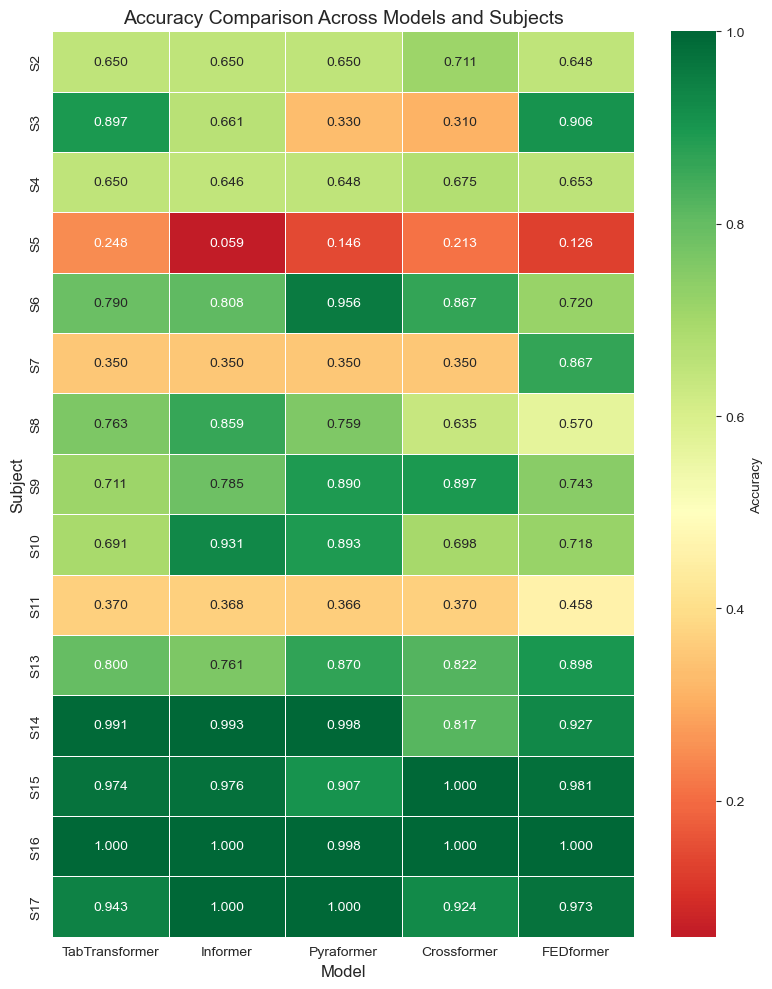

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 10))

sns.heatmap(
    acc_combined,
    annot=True,
    fmt=".3f",
    cmap="RdYlGn",
    center=0.5,
    linewidths=0.5,
    cbar_kws={"label": "Accuracy"}
)

plt.title("Accuracy Comparison Across Models and Subjects", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Subject", fontsize=12)

plt.tight_layout()
plt.show()

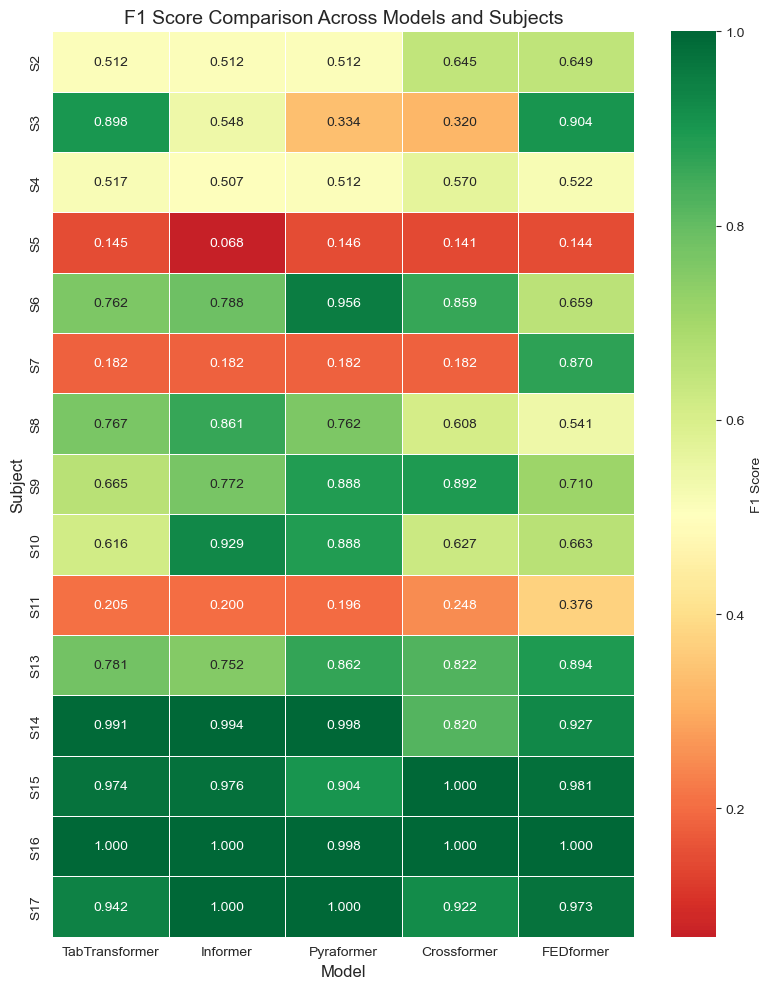

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 10))

sns.heatmap(
    f1_combined,
    annot=True,
    fmt=".3f",
    cmap="RdYlGn",
    center=0.5,
    linewidths=0.5,
    cbar_kws={"label": "F1 Score"}
)

plt.title("F1 Score Comparison Across Models and Subjects", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Subject", fontsize=12)

plt.tight_layout()
plt.show()

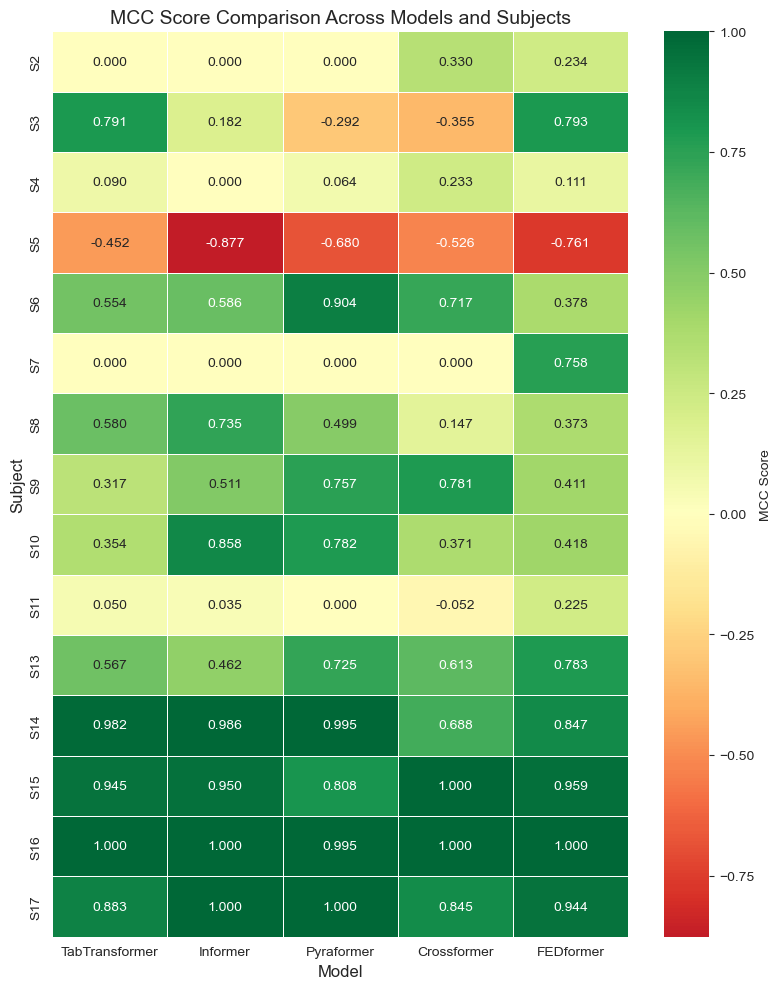

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 10))

sns.heatmap(
    mcc_combined,
    annot=True,
    fmt=".3f",
    cmap="RdYlGn",
    center=0,
    linewidths=0.5,
    cbar_kws={"label": "MCC Score"}
)

plt.title("MCC Score Comparison Across Models and Subjects", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Subject", fontsize=12)

plt.tight_layout()
plt.show()